In [28]:
!pip install -q transformers praw torch scipy seaborn matplotlib


In [29]:
import praw

# Ask user for credentials securely
client_id = input("🔑 Enter your Reddit client ID: ")
client_secret = input("🔐 Enter your Reddit client secret: ")
user_agent = "meme_coin_sentiment_app"

# Create Reddit connection
reddit = praw.Reddit(
    client_id=client_id,
    client_secret=client_secret,
    user_agent=user_agent
)

# Test connection
subreddit = reddit.subreddit("dogecoin")  # You can change to 'cryptoCurrency' or others
for post in subreddit.hot(limit=3):
    print("✅", post.title)


🔑 Enter your Reddit client ID: IHZpTuG2al6L2AIXKyi2yw
🔐 Enter your Reddit client secret: HHVCt9BTFf6R-C5eNIG7wHLBzfIF7A


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ 🚀 HOW TO BUY DOGECOIN!! 🚀
✅ DOGECOIN DAILY DISCUSSION
✅ My doge had 9 puppies last night 🥳


In [30]:
import pandas as pd
import datetime

def fetch_reddit_posts(subreddit_name="dogecoin", limit=300):
    subreddit = reddit.subreddit(subreddit_name)

    posts = []
    for post in subreddit.hot(limit=limit):
        posts.append({
            "title": post.title,
            "text": post.selftext,
            "score": post.score,
            "num_comments": post.num_comments,
            "created_utc": datetime.datetime.fromtimestamp(post.created_utc)
        })

    return pd.DataFrame(posts)

# Fetch posts from r/dogecoin
df_posts = fetch_reddit_posts(limit=300)
df_posts.head()


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



,title,text,score,num_comments,created_utc
0,🚀 HOW TO BUY DOGECOIN!! 🚀,This post is updated for Feb 2024!!\n\n\nPleas...,2471,15728,2021-11-11 09:16:59
1,DOGECOIN DAILY DISCUSSION,Hi Shibes.\n\nWelcome to this weeks discussion...,27,11,2025-07-22 02:51:28
2,My doge had 9 puppies last night 🥳,,983,36,2025-07-28 02:35:59
3,💚🐶 Inevitable 🚀🚀🚀🌕,,28,1,2025-07-28 10:44:21
4,Why DOGE won’t fail,Doge will not fail because of this. A group wi...,68,47,2025-07-28 00:12:06


In [31]:
import re

def clean_text(text):
    if not isinstance(text, str):
        return ""

    text = re.sub(r"http\S+|www\S+", "", text)  # remove links
    text = re.sub(r"\n+", " ", text)  # remove newlines
    text = re.sub(r"[^\w\s]", "", text)  # remove punctuation
    text = re.sub(r"\s+", " ", text)  # collapse spaces
    return text.strip()

# Combine title and post body
df_posts["combined"] = df_posts["title"] + " " + df_posts["text"]
df_posts["clean_text"] = df_posts["combined"].apply(clean_text)

# Preview cleaned text
df_posts[["clean_text"]].head()


,clean_text
0,HOW TO BUY DOGECOIN This post is updated for F...
1,DOGECOIN DAILY DISCUSSION Hi Shibes Welcome to...
2,My doge had 9 puppies last night
3,Inevitable
4,Why DOGE wont fail Doge will not fail because ...


In [32]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import torch

# Load tokenizer and model
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# Define labels
labels = ['negative', 'neutral', 'positive']


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [33]:
# Predict sentiment with softmax confidence
def predict_sentiment(text):
    text = text.strip().replace("\n", " ")
    encoded_input = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)

    with torch.no_grad():
        output = model(**encoded_input)

    scores = softmax(output.logits.numpy()[0])
    sentiment = labels[scores.argmax()]
    confidence = float(scores.max())
    return sentiment, confidence


In [34]:
# Apply to first 100 rows (can scale later)
results = df_posts["clean_text"][:100].apply(predict_sentiment)

# Store results
df_posts.loc[:99, "sentiment"] = results.apply(lambda x: x[0])
df_posts.loc[:99, "confidence"] = results.apply(lambda x: x[1])

# Preview
df_posts[["clean_text", "sentiment", "confidence"]].head(10)


,clean_text,sentiment,confidence
0,HOW TO BUY DOGECOIN This post is updated for F...,neutral,0.533531
1,DOGECOIN DAILY DISCUSSION Hi Shibes Welcome to...,neutral,0.520690
2,My doge had 9 puppies last night,neutral,0.761533
3,Inevitable,negative,0.782670
4,Why DOGE wont fail Doge will not fail because ...,positive,0.829557
5,Lost 500 Due to a Dumb Move Anyone Else Been T...,negative,0.676383
6,Lets go 25 bucks every day,neutral,0.793066
7,Lets move DOGE to 050 If youre holding stay st...,positive,0.559016
8,Set and forget,neutral,0.645074
9,HODL,neutral,0.539142


/tmp/ipython-input-35-3967677401.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_posts[:100], x="sentiment", palette="pastel")


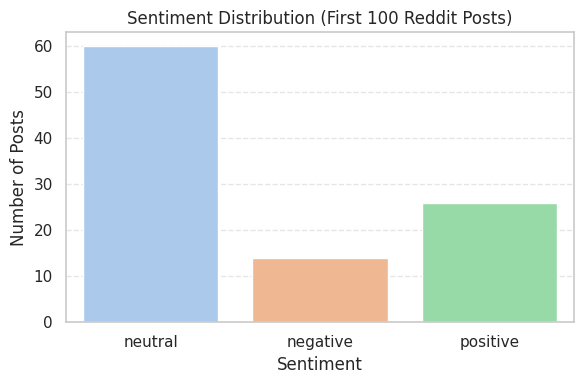

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count plot of sentiment
plt.figure(figsize=(6, 4))
sns.countplot(data=df_posts[:100], x="sentiment", palette="pastel")
plt.title("Sentiment Distribution (First 100 Reddit Posts)")
plt.xlabel("Sentiment")
plt.ylabel("Number of Posts")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


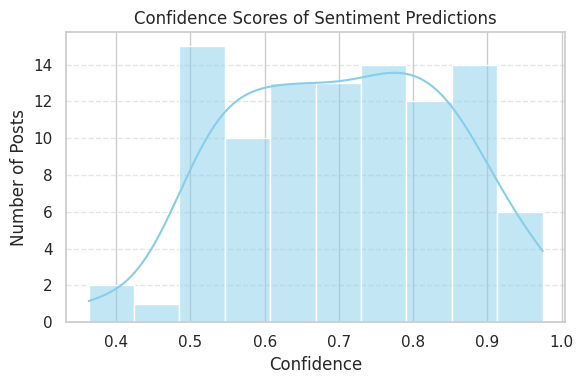

In [36]:
# Confidence scores histogram
plt.figure(figsize=(6, 4))
sns.histplot(data=df_posts[:100], x="confidence", bins=10, kde=True, color="skyblue")
plt.title("Confidence Scores of Sentiment Predictions")
plt.xlabel("Confidence")
plt.ylabel("Number of Posts")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
